In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time
from matplotlib import colors

if 'path' in locals(): os.chdir(path)
else: os.chdir("../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/"
from pyMFI import MFI
from pyMFI import MFI1D
from pyMFI import run_plumed

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 22})
boldfont = {'fontname':'Helvetica', 'fontweight':'bold'}

plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

grid = np.linspace(-3, 3, 200); 
X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)
inve_cut_19 = np.where(inve_pot < 19, 1, 0)

The path is: /home/ucecabj/Desktop/pyMFI_git


#### (1) - Running long simulations

In [4]:
#Run simulation 
# os.chdir(path_manustript + "Figure2")

# # Run simulation
# run_plumed.run_2D_Invernizzi(simulation_steps=10000000, gaus_pace=500, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=1, initial_position_y=-1, file_extension="long")

In [2]:
os.chdir(path_manustript + "Figure2")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_long")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="positioninve_long")

#COMPUTE Mean force and weight of the simulation
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.05, bw_y = 0.05, kT = 1, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), error_pace = 100, FES_cutoff=-1, nhills=10000)

#integration on a non-periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)))

#Find Absolute devaition
AD = abs(inve_pot - FES)
ADc = np.where(inve_pot < 19, AD, 0)
AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
AADc = np.sum(ADc)/(np.count_nonzero(ADc))
print("AAD =" ,round(AAD,2) , "   |    AAD_(where inve_pot<19kJ/mol) =", round(AADc,2))

[FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1] = [FES, Ftot_den, ofe, AD, cutoff, time_history[1:], ofe_history[1:]]

|**************************************************| 100% | Average Mean Force Error: 26.317AAD = 33.38    |    AAD_(where inve_pot<19kJ/mol) = 0.63


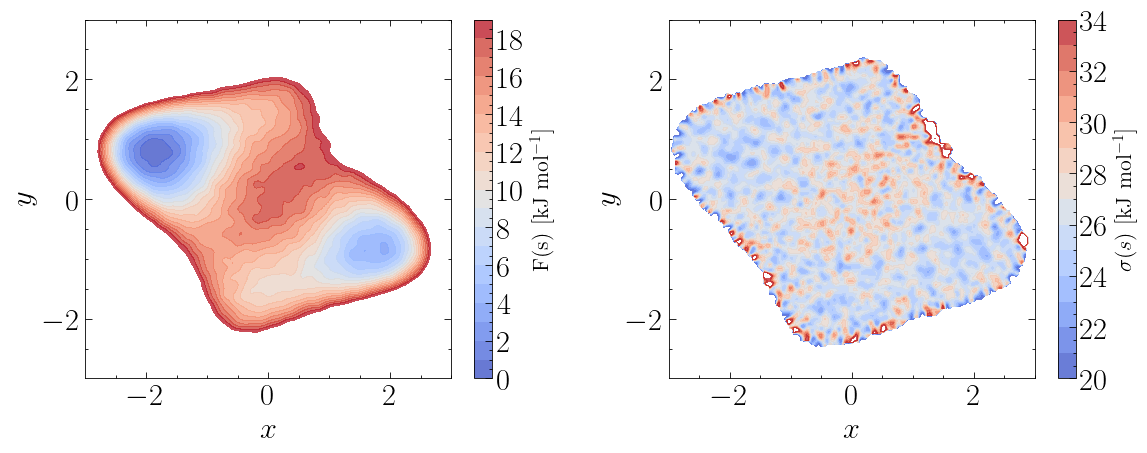

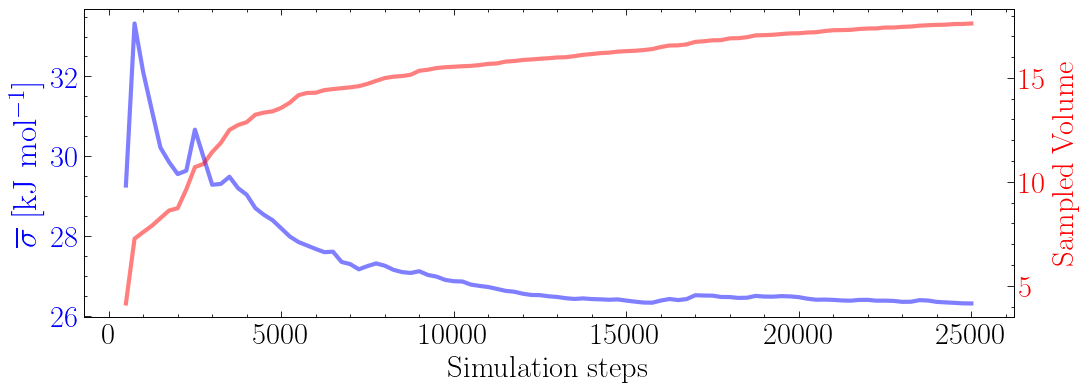

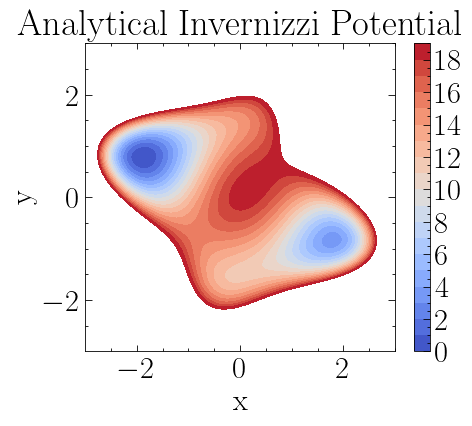

In [4]:
# Plot 1 
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cp = axs[0].contourf(X, Y, FES, levels=np.arange(0, 20, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


cp = axs[1].contourf(X, Y, ofe*cutoff, levels=np.arange(20, 35, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$]",fontsize=16)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()    

plt.savefig('Figure2_A', dpi=600, bbox_inches='tight')

fig, axs = plt.subplots(1, 1, figsize=(12, 4))

OFE_history_long=ofe_history[1:]
time_OFE_history_long=[time for time in time_history[1:]]

axs.plot( [time for time in time_history[1:]], (ofe_history[1:]),color='blue',alpha=0.5,linewidth=3);
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='blue')
axs.tick_params(axis ='y', labelcolor = 'blue')
axs.set_xlabel('Simulation steps')

ax2 = axs.twinx()
ax2.set_xlabel('Simulation steps')
ax2.set_ylabel('Sampled Volume',color='red')
ax2.tick_params(axis ='y', labelcolor = 'red')
ax2.plot( [time for time in time_history[1:]], np.multiply(volume_history[1:],np.power(6,2)),color='red',alpha=0.5,linewidth=3);

plt.savefig('Figure2B', dpi=600, bbox_inches='tight')


grid = np.linspace(-3, 3, 200); 
X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)

plt.figure(figsize=(5,4)); 
plt.contourf(X, Y, inve_pot, levels=range(0, 20, 1), cmap='coolwarm')
plt.xlabel("x"); plt.ylabel("y"); 
plt.title("Analytical Invernizzi Potential"); 
plt.colorbar()
plt.show()


#### (2) - Running multiple short simulations

In [5]:
#Run simulation
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential")

# simulation_steps = 250000
#for simulation in np.arange(0,n_simulations): 
    #print('Simulation: '+str(simulation), end="  |   ")
    #file_extension="" + str(int(simulation))
    
    #RUN short sim from random location
    #ipos=1.3*(2 * np.random.rand(2) - 1)
    #run_plumed.run_2D_Invernizzi(simulation_steps=simulation_steps, gaus_pace=500, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=ipos[0], initial_position_y=ipos[1], file_extension=file_extension)
    

In [3]:
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data")
pbt_bandwidth = 0.05
n_simulations = 20

master = []
master_patch = [[np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200))]]
ofe_history_patch = [0]
ofe_history_patch_time = [0]

for simulation in np.arange(0,n_simulations): 
    
    file_extension="inve_" + str(int(simulation))
    # print('\nSimulation: ' + str(simulation) + ' (ext=' + str(file_extension) + ')' )

    #Read the HILLS and position file file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLS" + file_extension)
    [position_x, position_y] = MFI.load_position_2D(position_name="position" + file_extension)

    #COMPUTE Mean force and weight of the simulation
    results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = pbt_bandwidth, bw_y = pbt_bandwidth, kT = 1, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), nbins=np.array((200, 200)), error_pace=100, base_terms = master_patch[-1])
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    
    #store results in master_array
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    #patch master and store result in master_patch
    master_patch.append(MFI.patch_2D(master))
    #save ofe history
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj

#shorten history to remove the first entry ([0])
ofe_history_patch = ofe_history_patch[1:]
ofe_history_patch_time = ofe_history_patch_time[1:]

|**************************************************| 100% | Average Mean Force Error: 28.471

In [4]:
    
#find "standard devaition of mean force" map
[ofv_patch, ofe_patch] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5])

#integration on a non-periodic! domain
[Xp, Yp, FES_patch] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=np.array((-3.0, -3.0)), max_grid=np.array((3.0, 3.0)))

cutoff_2 = MFI.get_cutoff(PD=master_patch[-1][0])

AD = abs(inve_pot - FES_patch)
ADc = np.where(inve_pot < 20, AD, 0)
AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
AADc = np.sum(ADc)/(np.count_nonzero(ADc))
print(AAD)
print(AADc)

[FES_2, Ftot_den_2, ofe_2, AD_2, cutoff_2, time_history_2, ofe_history_2] = [FES_patch, master_patch[-1][0], ofe_patch, AD, cutoff_2, ofe_history_patch_time, ofe_history_patch]

39.00677690352448
2.7223141639415145


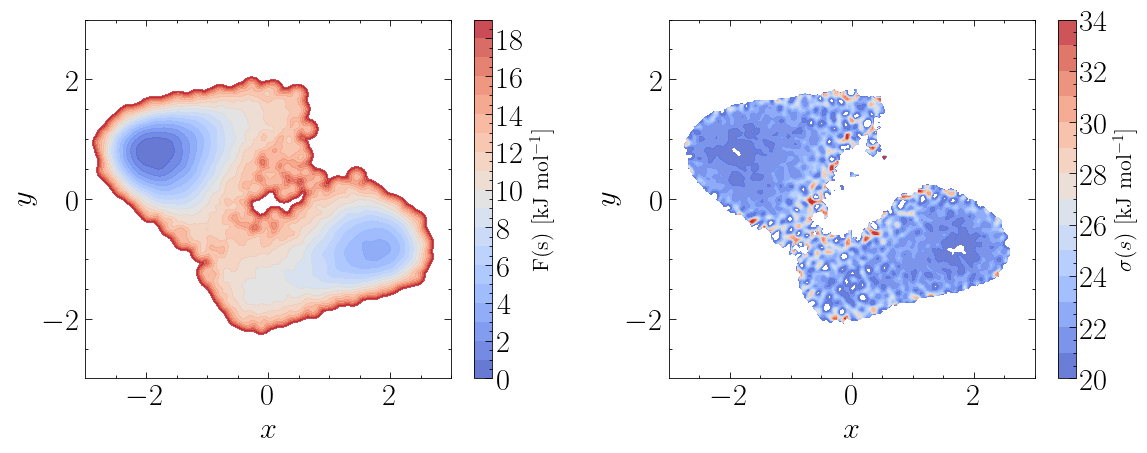

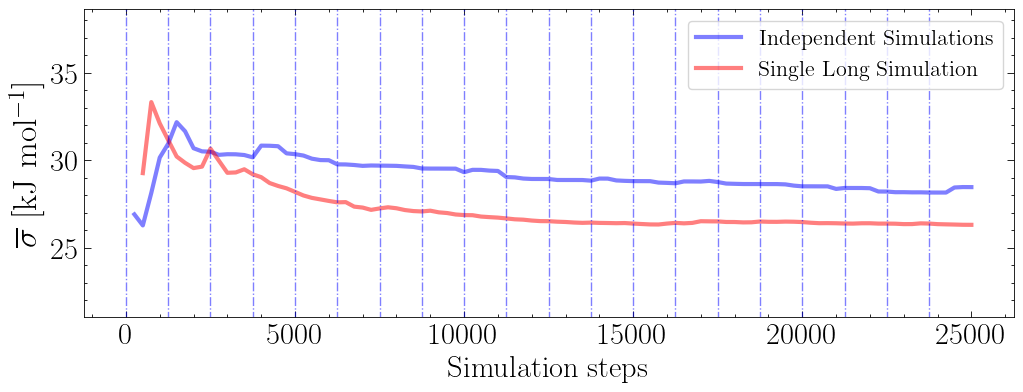

In [9]:
# plot 2
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data")

#make "sim_start" list with only the first entry of a simulation
sim_start = [ofe_history_patch_time[i] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i] for i in range(n_simulations)]

# Plot Results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cp = axs[0].contourf(Xp, Yp, FES_patch, levels=np.arange(0, 20, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


cp = axs[1].contourf(X, Y, ofe_patch*cutoff_2, levels=[35,200], cmap=colors.ListedColormap(['darkred']), antialiased=False, alpha=0.8);
cp = axs[1].contourf(X, Y, ofe_patch*cutoff_2, levels=np.arange(20, 35, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$]",fontsize=16)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()    

plt.savefig('Figure2_C', dpi=600, bbox_inches='tight')

fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot( [time for time in ofe_history_patch_time], (ofe_history_patch),color='blue',alpha=0.5,linewidth=3,label="Independent Simulations");
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='black')
axs.tick_params(axis ='y', labelcolor = 'black')

axs.plot( time_history_1, ofe_history_1 ,color='red',alpha=0.5,linewidth=3,label="Single Long Simulation");
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='black')

axs.set_xlabel('Simulation steps')

for i in np.arange(0,n_simulations):
    axs.plot([i*1250,i*1250],[20,50],'-.',color='blue',linewidth=1,alpha=0.5)

axs.set_ylim([min(ofe_history_patch)*0.8,max(ofe_history_patch)*1.2])

axs.legend(fontsize=16)

plt.savefig('Figure2_D', dpi=600, bbox_inches='tight')

#ax2 = axs.twinx()
#ax2.set_xlabel('Simulation steps')
#ax2.set_ylabel('Sampled Volume',color='red')
#ax2.tick_params(axis ='y', labelcolor = 'red')
#ax2.plot( [time for time in time_history[1:]], np.multiply(volume_history[1:],np.power(6/200,2)),color='red',alpha=0.5,linewidth=3);


In [5]:

print(len(master))
print(len(master_patch))

20
21


### NEW : instead of patching 20 normal simulations, only take 17 normal simulations and 3 HP simulations, focusing on the unexplored region in the centre

|**************************************************| 100% | Average Mean Force Error: 26.772

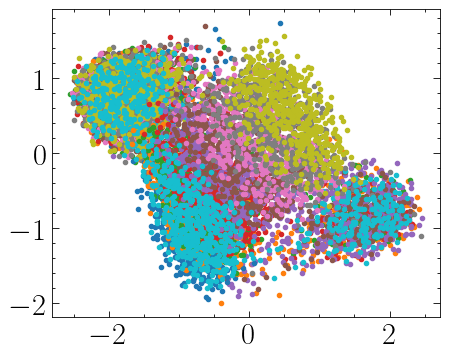

In [6]:
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data")


# Only take the results from the first 10 simulations and remove the last 3
n_old_sim = 10
master_2 = master[:-(20-n_old_sim)]
master_patch_2 = master_patch[:-(20-n_old_sim)]
ofe_history_patch_2 = ofe_history_patch[:-int((20-n_old_sim)*len(ofe_history_patch)/len(master))]
ofe_history_patch_time_2 = ofe_history_patch_time[:-int((20-n_old_sim)*len(ofe_history_patch)/len(master))]
for i in range(20-n_old_sim): 
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_" + str(i))
    plt.plot(HILLS[:,1],HILLS[:,2],'.')


#Add 3 MetaD simulations with static harmonic potentials
hp_centre = [[-1.2,-1.2],[-0.8, -0.8],[-0.6,-0.6],[-0.4,-0.4],[-0.2,-0.2],[0,0],[0.2,0.2],[0.4,0.4], [0.6, 0.6], [-1.0,-1.0]]
kappa = 20  

pbt_bandwidth = 0.05
for simulation in np.arange(0,len(hp_centre)):   
    # print("\nSimulation: ", simulation)          

    #Run simulation
    # run_plumed.run_2D_Invernizzi(simulation_steps=250000, gaus_pace=500, sigma=0.05, height=0.5, biasfactor=10, initial_position_x=hp_centre[simulation][0], initial_position_y=hp_centre[simulation][1],
    #             hp_centre_x=hp_centre[simulation][0], hp_centre_y=hp_centre[simulation][1], hp_kappa_x=kappa, hp_kappa_y=kappa, file_extension="HP_"+str(simulation))
                                            
    #Read the HILLS and position file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_HP_"+str(simulation))
    plt.plot(HILLS[:,1],HILLS[:,2],'.')
    [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_HP_"+str(simulation))
        
    #MFI with metaD and HP
    results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, 
                            bw_x = pbt_bandwidth, bw_y = pbt_bandwidth, kT = 1, error_pace = 100, base_terms = master_patch_2[-1], nhills=-1, 
                            min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), nbins=np.array((200, 200)), #FES_cutoff = 20, 
                            hp_centre_x=hp_centre[simulation][0], hp_centre_y=hp_centre[simulation][1], hp_kappa_x=kappa, hp_kappa_y=kappa)
    
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    
    #store results and patch with previous results
    master_2.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    master_patch_2.append(MFI.patch_2D(master_2))
    
    #save ofe history
    ofe_history_patch_2 += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time_2[-1] for element in time_history]
    ofe_history_patch_time_2 += ofe_history_time_adj
       
plt.show()

In [7]:
#find "standard devaition of mean force" map
[ofv_patch_2, ofe_patch_2] = MFI.mean_force_variance(master_patch_2[-1][0], master_patch_2[-1][1], master_patch_2[-1][2], master_patch_2[-1][3], master_patch_2[-1][4], master_patch_2[-1][5])

#integration on a non-periodic! domain
[Xp, Yp, FES_patch_2] = MFI.FFT_intg_2D(master_patch_2[-1][2], master_patch_2[-1][3], min_grid=np.array((-3.0, -3.0)), max_grid=np.array((3.0, 3.0)))

cutoff_3 = MFI.get_cutoff(PD=master_patch_2[-1][0])

AD_3 = abs(inve_pot - FES_patch_2)
ADc_3 = np.where(inve_pot < 20, AD_3, 0)
AAD_3 = np.sum(AD_3)/(FES_patch_2.shape[0]*FES_patch_2.shape[0])
AADc_3 = np.sum(ADc_3)/(np.count_nonzero(ADc_3))
print(AAD_3)
print(AADc_3)

[FES_3, Ftot_den_3, ofe_3, AD_3, cutoff_3, time_history_3, ofe_history_3] = [FES_patch_2, master_patch_2[-1][0], ofe_patch_2, AD_3, cutoff_3, ofe_history_patch_time_2, ofe_history_patch_2]

39.088405734944956
2.501057712368923


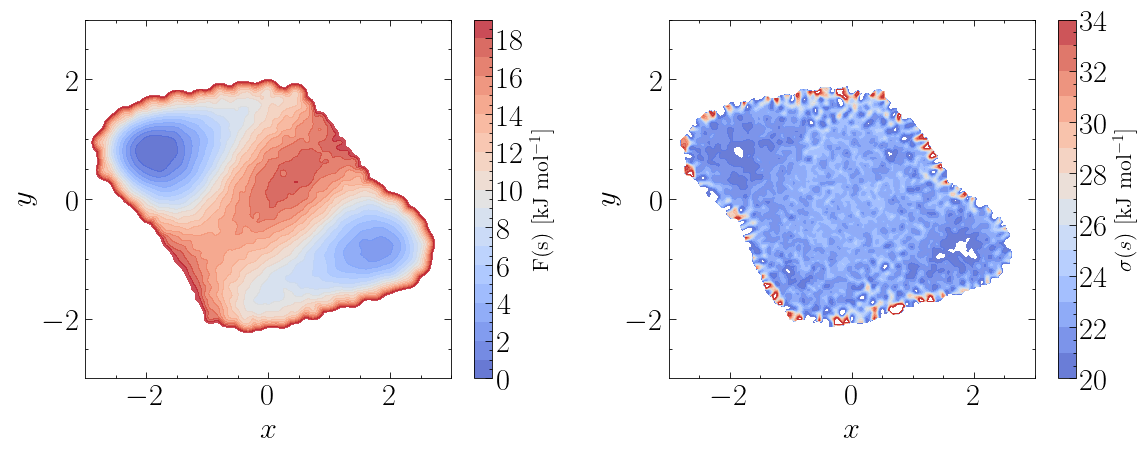

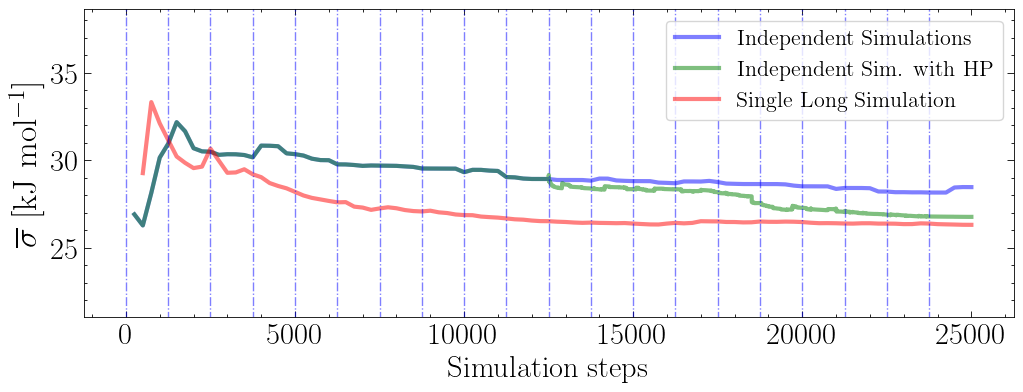

In [73]:
#plot 3
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data")

#make "sim_start" list with only the first entry of a simulation
sim_start = [ofe_history_patch_time[i] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i] for i in range(n_simulations)]

# Plot Results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cp = axs[0].contourf(Xp, Yp, FES_patch_2, levels=np.arange(0, 20, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


cp = axs[1].contourf(X, Y, ofe_patch_2*cutoff, levels=np.arange(20, 35, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$]",fontsize=16)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()    

plt.savefig('Figure2_C', dpi=600, bbox_inches='tight')

fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot( [time for time in ofe_history_patch_time], (ofe_history_patch),color='blue',alpha=0.5,linewidth=3,label="Independent Simulations");
axs.plot( [time for time in ofe_history_patch_time_2], (ofe_history_patch_2),color='green',alpha=0.5,linewidth=3,label="Independent Sim. with HP");
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='black')
axs.tick_params(axis ='y', labelcolor = 'black')

axs.plot( time_OFE_history_long, OFE_history_long ,color='red',alpha=0.5,linewidth=3,label="Single Long Simulation");
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='black')

axs.set_xlabel('Simulation steps')

for i in np.arange(0,n_simulations):
    axs.plot([i*1250,i*1250],[20,50],'-.',color='blue',linewidth=1,alpha=0.5)

axs.set_ylim([min(ofe_history_patch_2)*0.8,max(ofe_history_patch_2)*1.2])

axs.legend(fontsize=16)

plt.savefig('Figure2_D', dpi=600, bbox_inches='tight')

#ax2 = axs.twinx()
#ax2.set_xlabel('Simulation steps')
#ax2.set_ylabel('Sampled Volume',color='red')
#ax2.tick_params(axis ='y', labelcolor = 'red')
#ax2.plot( [time for time in time_history[1:]], np.multiply(volume_history[1:],np.power(6/200,2)),color='red',alpha=0.5,linewidth=3);


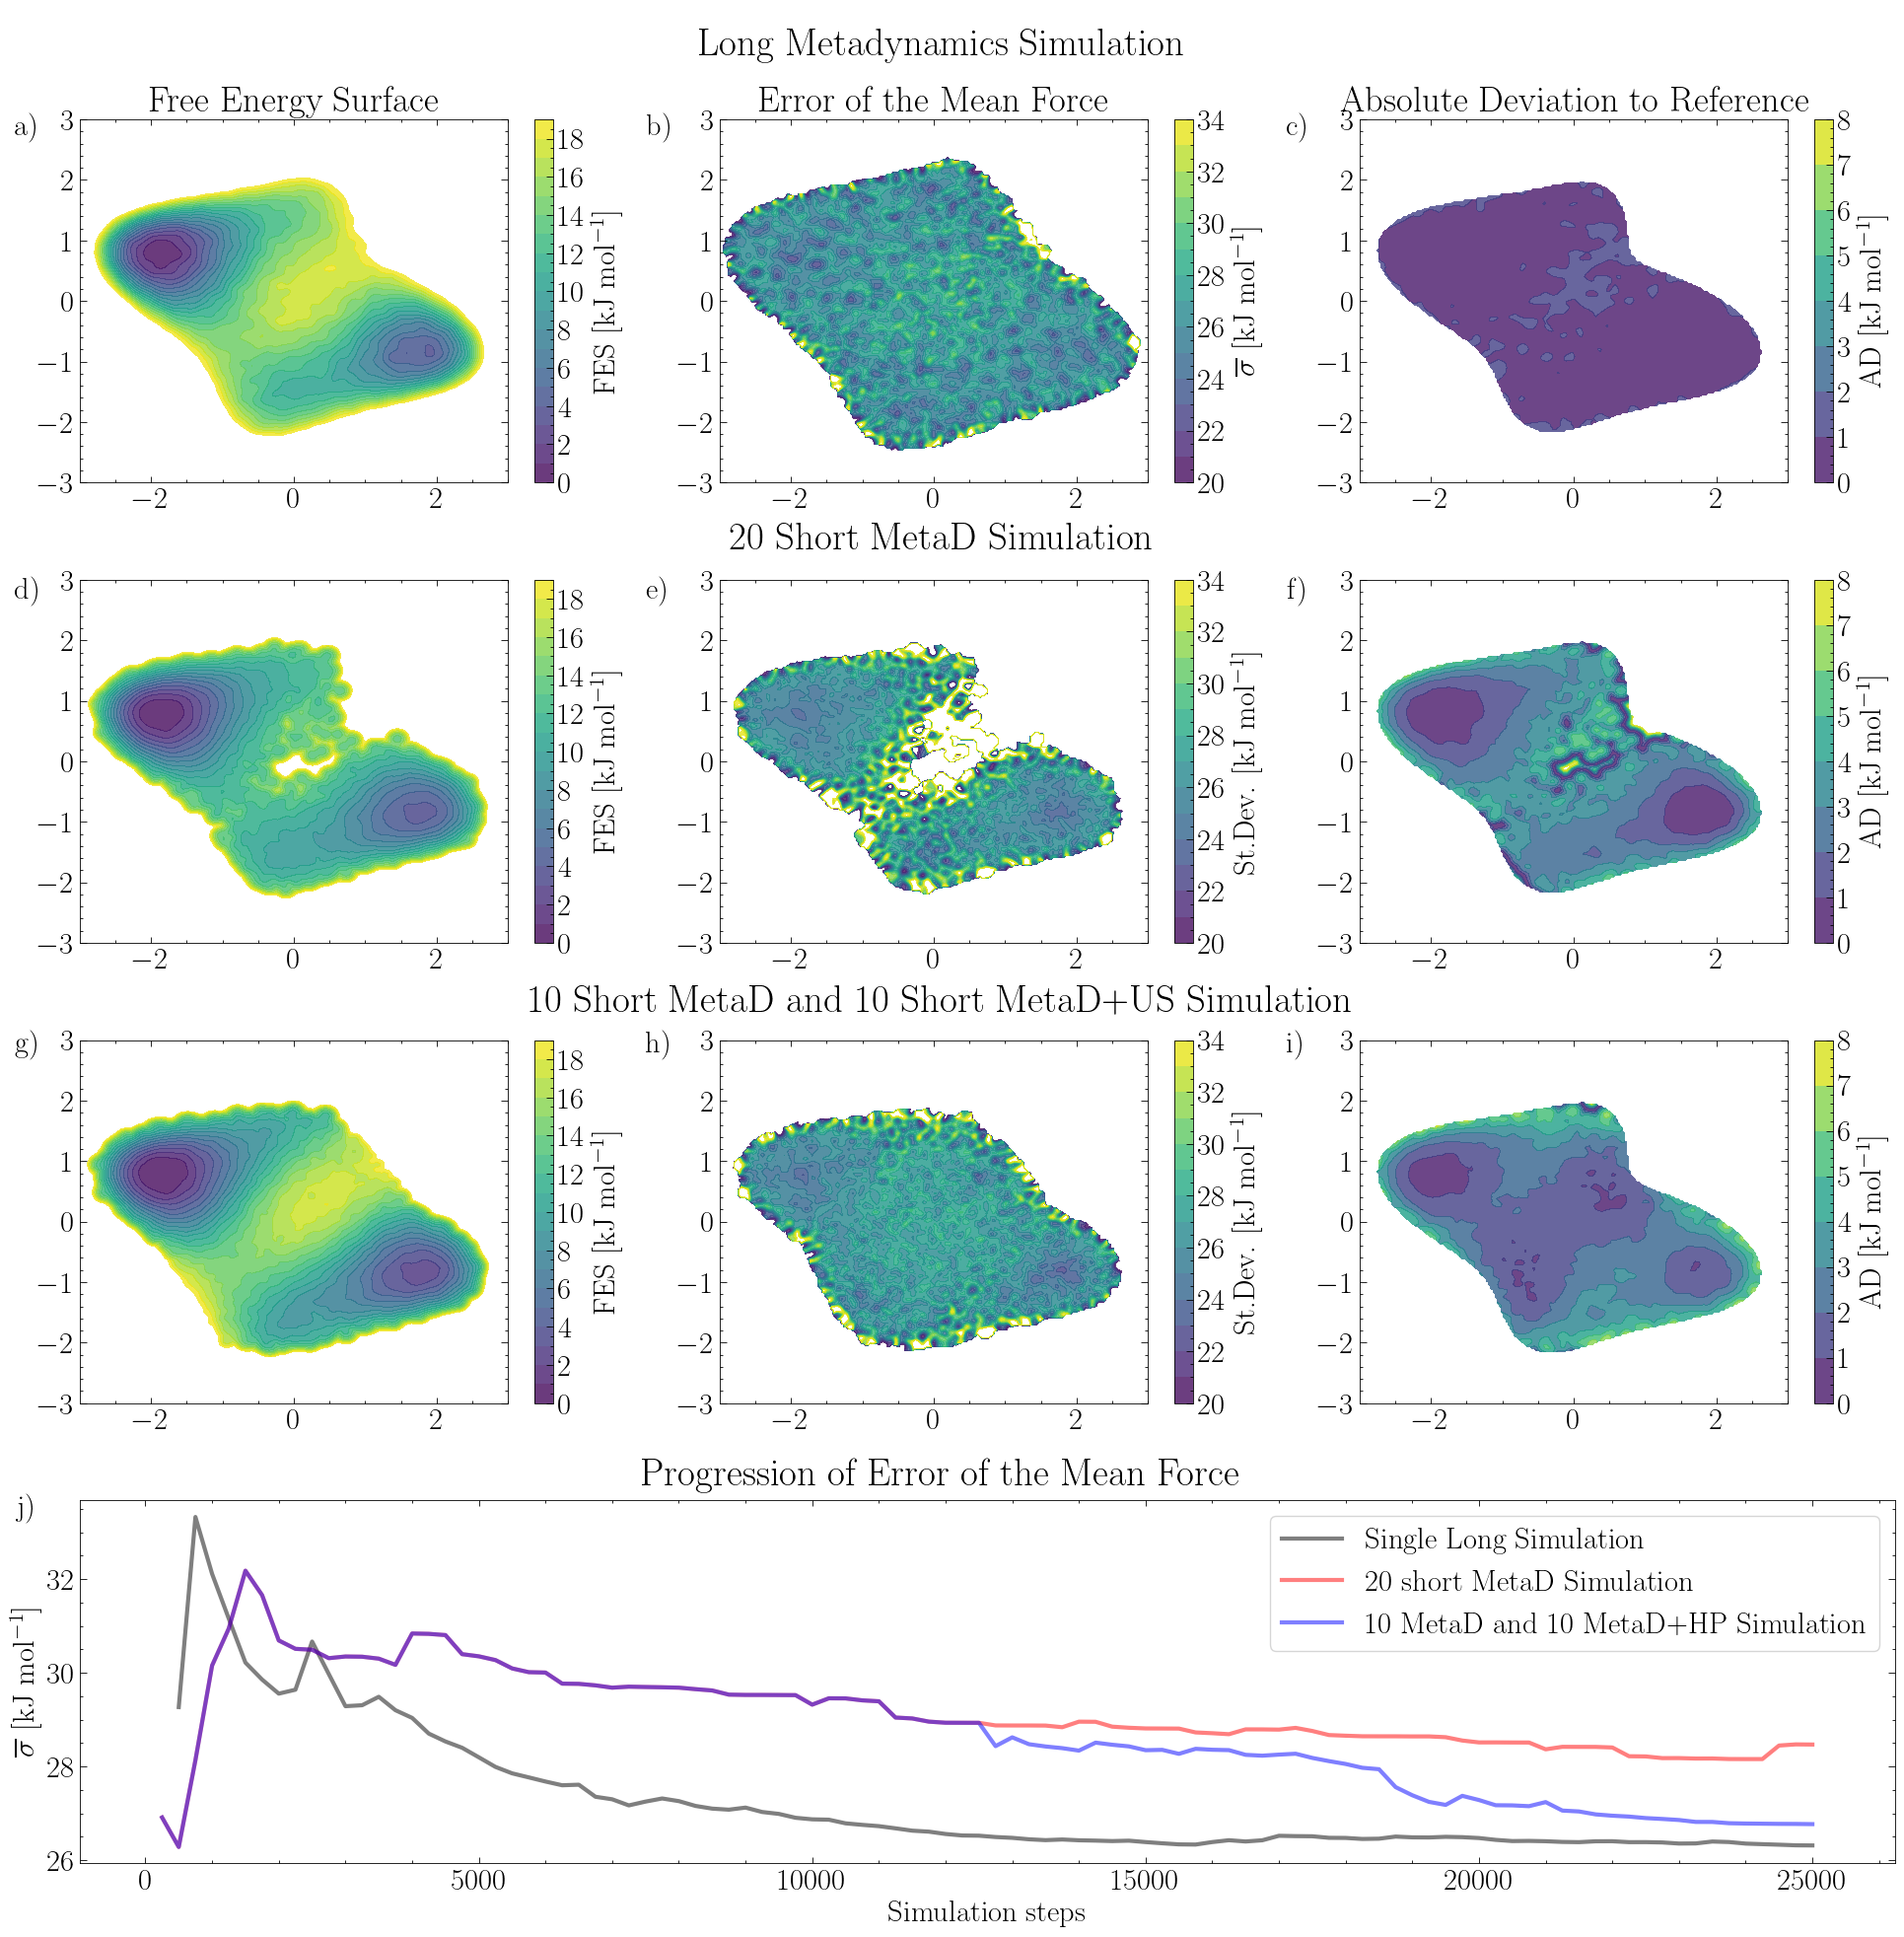

In [44]:
fig = plt.figure(1,figsize=(20,20))
plt.subplot(4,3,1)
plt.contourf(X,Y,FES_1, levels=np.arange(0, 20, 1), cmap='viridis', antialiased=False, alpha=0.8)
plt.title("Free Energy Surface")
plt.colorbar(label="FES [kJ mol$^{-1}$]")
# plt.ylabel("CV2")
plt.subplot(4,3,2)
plt.contourf(X,Y,ofe_1*cutoff_1, levels=np.arange(20,35, 1), cmap='viridis', antialiased=False, alpha=0.8)
plt.title("Error of the Mean Force")
plt.colorbar(label="$\overline{\sigma}$ [kJ mol$^{-1}$]")
plt.subplot(4,3,3)
plt.contourf(X,Y,MFI.zero_to_nan(AD_1*inve_cut_19), levels=np.arange(0,9, 1), cmap='viridis', antialiased=False, alpha=0.8)
plt.title("Absolute Deviation to Reference")
plt.colorbar(label="AD [kJ mol$^{-1}$]")

plt.subplot(4,3,4)
plt.contourf(X,Y,FES_2, levels=np.arange(0, 20, 1), cmap='viridis', antialiased=False, alpha=0.8)
plt.colorbar(label="FES [kJ mol$^{-1}$]")
# plt.ylabel("CV2")
plt.subplot(4,3,5)
plt.contourf(X,Y,ofe_2*cutoff_2, levels=np.arange(20,35, 1), cmap='viridis', antialiased=False, alpha=0.8)
plt.colorbar(label="St.Dev. [kJ mol$^{-1}$]")
plt.subplot(4,3,6)
plt.contourf(X,Y,MFI.zero_to_nan(AD_2*inve_cut_19), levels=np.arange(0,9, 1), cmap='viridis', antialiased=False, alpha=0.8)
plt.colorbar(label="AD [kJ mol$^{-1}$]")

plt.subplot(4,3,7)
plt.contourf(X,Y,FES_3, levels=np.arange(0, 20, 1), cmap='viridis', antialiased=False, alpha=0.8)
plt.colorbar(label="FES [kJ mol$^{-1}$]")
# plt.ylabel("CV2")
# plt.xlabel("CV1")
plt.subplot(4,3,8)
plt.contourf(X,Y,ofe_3*cutoff_3, levels=np.arange(20,35, 1), cmap='viridis', antialiased=False, alpha=0.8)
plt.colorbar(label="St.Dev. [kJ mol$^{-1}$]")
# plt.xlabel("CV1")
plt.subplot(4,3,9)
plt.contourf(X,Y,MFI.zero_to_nan(AD_3*inve_cut_19), levels=np.arange(0,9, 1), cmap='viridis', antialiased=False, alpha=0.8)
plt.colorbar(label="AD [kJ mol$^{-1}$]")
# plt.xlabel("CV1")

plt.subplot(4,1,4)
plt.plot( time_history_1, ofe_history_1 ,color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
plt.plot( time_history_2, ofe_history_2 ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulation")
plt.plot( time_history_3, ofe_history_3 ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulation")
plt.xlabel("Simulation steps"); plt.ylabel("$\overline{\sigma}$ [kJ mol$^{-1}$]")
plt.legend();

plt.subplots_adjust(hspace=3)
plt.suptitle(' ', ha='center', va='center', fontsize=28, fontweight='bold')
fig.text(0.5, 0.97, 'Long Metadynamics Simulation', ha='center', va='center', fontsize=28, fontweight='bold')
fig.text(0.5, 0.72, '20 Short MetaD Simulation', ha='center', va='center', fontsize=28, fontweight='bold')
fig.text(0.5, 0.485, '10 Short MetaD and 10 Short MetaD+US Simulation', ha='center', va='center', fontsize=28, fontweight='bold')
fig.text(0.5, 0.245, 'Progression of Error of the Mean Force', ha='center', va='center', fontsize=28, fontweight='bold')

# fig = plt.figure(1,figsize=(20,20))
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["font.weight"] = "bold"

fig.text(0.03, 0.925, "a)", **boldfont)
fig.text(0.35, 0.925, "b)")
fig.text(0.675, 0.925, "c)")

fig.text(0.03, 0.69, "d)")
fig.text(0.35, 0.69, "e)")
fig.text(0.675, 0.69, "f)")

fig.text(0.03, 0.46, "g)")
fig.text(0.35, 0.46, "h)")
fig.text(0.675, 0.46, "i)")

fig.text(0.03, 0.225, "j)")



plt.tight_layout(); 
plt.savefig(path_manustript + 'Figure3/Figure3_inv_x12.png', dpi=600, bbox_inches='tight')

plt.show()